# [IAPR 2020:][iapr2020] Lab 2 ‒  Object description

**Authors:** first_name_1 last_name_1, first_name_2 last_name_2, first_name_3 last_name_3  
**Due date:** 24.04.2020

[iapr2020]: https://github.com/LTS5/iapr-2020

## Extract relevant data
We first need to extract the `lab-02-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [5]:
import tarfile
import os

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-02-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

## Part 1
In the `lab-02-data/part1` folder, you will find 28x28 grey-scale pictures of handwritten "0" and "1".
These digits have been extracted from MNIST dataset (http://yann.lecun.com/exdb/mnist/).

Your goal is to extract, from each of those images, a 2-dimensional feature vector (i.e. 2 features) and to plot them all on a 2D graph.
If you have chosen good features, the vectors of the "0"'s should nicely cluster in one part of the plane and those of the "1"'s in another.

Please try first the Fourier Descriptors.
You can make several attempts: e.g. with and without invariance to rotation, translation, scaling, etc.
You can also for instance rotate the images and assess the invariance in rotation.

**Note:** for the Fourier descriptors, the u_k signal has to be constructed by following the contour point after point.
Some pre-processing (image binarization, possibly some Mathematical Morphology) might be useful.

Then feel free to try other features, the more you try, the better it will be (for you).

### 1.1 Data visualization

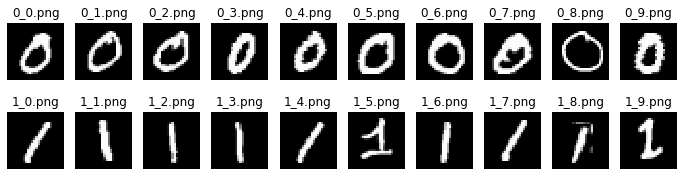

In [6]:
import skimage.io
import matplotlib.pyplot as plt
%matplotlib inline

# Load images
data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-02-data'
#  Load zeros
zeros_path = os.path.join(data_base_path, data_folder, 'part1', '0')
zeros_names = [nm for nm in os.listdir(zeros_path) if '.png' in nm]  # make sure to only load .png
zeros_names.sort()  # sort file names
ic = skimage.io.imread_collection([os.path.join(zeros_path, nm) for nm in zeros_names])
zeros_im = skimage.io.concatenate_images(ic)
#  Load ones
ones_path = os.path.join(data_base_path, data_folder, 'part1', '1')
ones_names = [nm for nm in os.listdir(ones_path) if '.png' in nm]  # make sure to only load .png
ones_names.sort()  # sort file names
ic = skimage.io.imread_collection(([os.path.join(ones_path, nm) for nm in ones_names]))
ones_im = skimage.io.concatenate_images(ic)

# Plot images
fig, axes = plt.subplots(2, len(zeros_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], zeros_im, zeros_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], ones_im, ones_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

### 1.2 Fourier descriptors
Add your implementation and discussion

### Invariances rotation, translation, scaling -- MS, CV, WJ

In [7]:
from skimage import feature
import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage
import skimage.measure as measure

# Convert contour into complex signals
def convert_signal(contour):
    output = np.zeros((np.array(contour).shape[0],1))
    output = contour[:,0] + 1j*contour[:,1] # Check if contour points are successive!
    return output



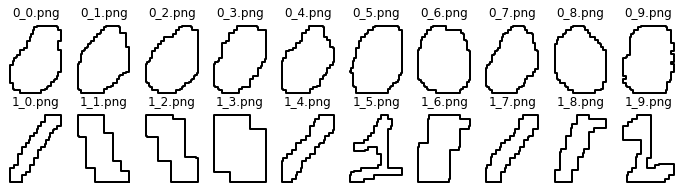

In [8]:
fig, axes = plt.subplots(2, len(zeros_im), figsize=(12, 3))
contourf_1 = []
contourf_0 = []
# Contour detection
for ax, im, nm in zip(axes[0], zeros_im, zeros_names):
    im = ndimage.binary_fill_holes(im) #Outer contour only or multiple contours??
    contours = measure.find_contours(im, 0.8)
    contour = sorted(contours, key=lambda x: len(x))[-1]
    contourf = convert_signal(contour)
    contourf_0.append(contourf)
    ax.step(contour[:,1], -contour[:,0], linewidth=2, c='k')
    ax.axis('off')
    ax.set_title(nm)
    
for ax, im, nm in zip(axes[1], ones_im, ones_names):
    im = ndimage.binary_fill_holes(im)
    kernel = np.ones((3,3), np.uint8)
    im = ndimage.binary_opening(im, kernel, iterations=1) 
    contours = measure.find_contours(im, 0.9)
    contour = sorted(contours, key=lambda x: len(x))[-1]
    contourf = convert_signal(contour)
    contourf_1.append(contourf)
#     ax.imshow(im)
    ax.step(contour[:,1], -contour[:,0], linewidth=2, c='k')
    ax.axis('off')
    ax.set_title(nm)
contourf_1 = np.array(contourf_1)
contourf_0 = np.array(contourf_0)

In [ ]:
f1 = 1
f2 = 4
div = -1



FD_0 = np.zeros((10,2),dtype=complex)
FD_1 = np.zeros((10,2),dtype=complex)

N = np.min(fft1.shape[0], fft.shape[1])
for i in range(10):
    fft0 = np.fft.fft(contourf_0[i])
    fft1 = np.fft.fft(contourf_1[i])
    
    FD_0[i,:]  = np.abs([fft0[f1],fft0[f2]])/np.abs(fft0[div])  # Scaling and rotation invariance applied
    FD_1[i,:]  = np.abs([fft1[f1],fft1[f2]])/np.abs(fft1[div])


75

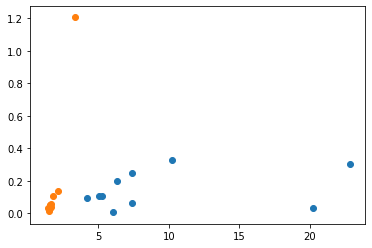

In [118]:
plt.scatter(FD_0[:,0],FD_0[:,1]) # what to do with complex numbers? Drop them or take amplitude?
plt.scatter(FD_1[:,0],FD_1[:,1])


### 1.3 Additional method(s)
Add your implementation and discussion

### Skeleton

### PCA -- MS

### Compacity -- CV

### Freeman Code


### Moments -- WJ


## Part 2
The `lab-02-data/part2` folder contains grey-scale pictures of handwritten "2" and "3".
Extract the same feature (typically 2 Fourier descriptors) as in part 1 also on these images and plot them on the same graph as the features of the "0" and "1".
Is it possible to discriminate all these 4 digits with a 2-dimensional feature vector?

### 2.1 Data visualization

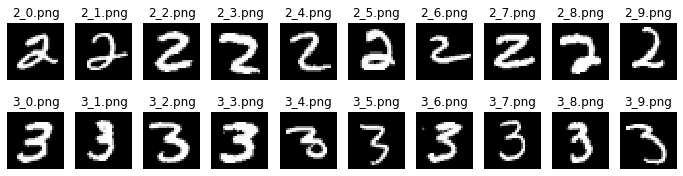

In [11]:
#  Load zeros
twos_path = os.path.join(data_base_path, data_folder, 'part2', '2')
twos_names = [nm for nm in os.listdir(twos_path) if '.png' in nm]  # make sure to only load .png
twos_names.sort()  # sort file names
ic = skimage.io.imread_collection([os.path.join(twos_path, nm) for nm in twos_names])
twos_im = skimage.io.concatenate_images(ic)
#  Load ones
threes_path = os.path.join(data_base_path, data_folder, 'part2', '3')
threes_names = [nm for nm in os.listdir(threes_path) if '.png' in nm]  # make sure to only load .png
threes_names.sort()  # sort file names
ic = skimage.io.imread_collection(([os.path.join(threes_path, nm) for nm in threes_names]))
threes_im = skimage.io.concatenate_images(ic)

# Plot images
fig, axes = plt.subplots(2, len(twos_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], twos_im, twos_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], threes_im, threes_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

### 2.2 Additional method(s) and conclusion
Add your implementations and discussions here

In [12]:
# Next meeting tentative April 4th!